In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

# Modified plot_decision_regions to avoid edgecolor warnings
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    markers = ('o', 's', '^')  # Filled markers
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx], marker=markers[idx], label=cl)

    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='none', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o', s=100, label='test set')
    plt.legend(loc='upper left')

# Load Iris dataset
iris = load_iris()
X = iris.data[:, [2, 3]]  # Petal length and width
y = iris.target

# Split and standardize Iris
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# Load moons dataset
X_moons, y_moons = make_moons(n_samples=100, random_state=123)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_moons, y_moons, test_size=0.3, random_state=1)
sc_m = StandardScaler()
sc_m.fit(X_train_m)
X_train_m_std = sc_m.transform(X_train_m)
X_test_m_std = sc_m.transform(X_test_m)
X_combined_m_std = np.vstack((X_train_m_std, X_test_m_std))
y_combined_m = np.hstack((y_train_m, y_test_m))

# Non-standardized combined for trees/forests
X_combined = np.vstack((X_train, X_test))

In [2]:
print("Class distribution (Iris train):", np.bincount(y_train))
print("Moons class distribution (train):", np.bincount(y_train_m))

Class distribution (Iris train): [35 35 35]
Moons class distribution (train): [35 35]


Accuracy (eta0=0.01): 0.956


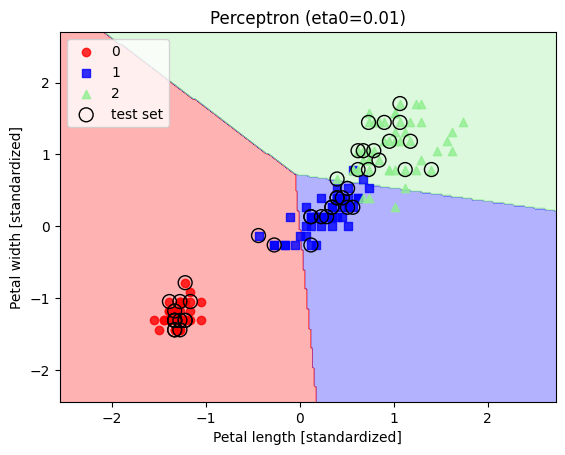

Accuracy (eta0=0.1): 0.978


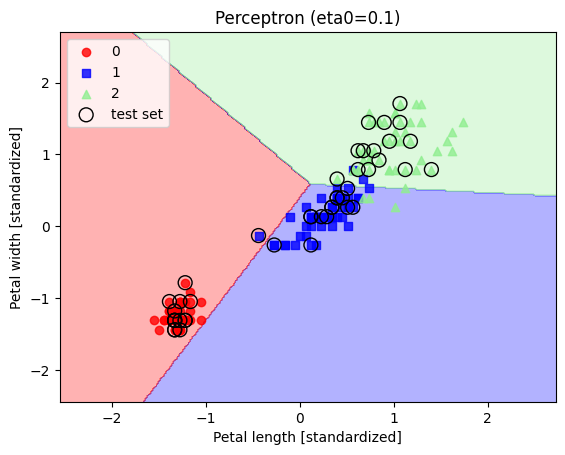

Accuracy (eta0=1): 0.889


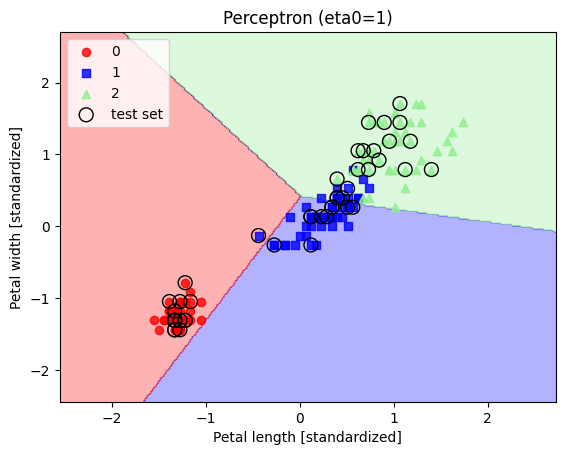

Moons Accuracy: 0.767


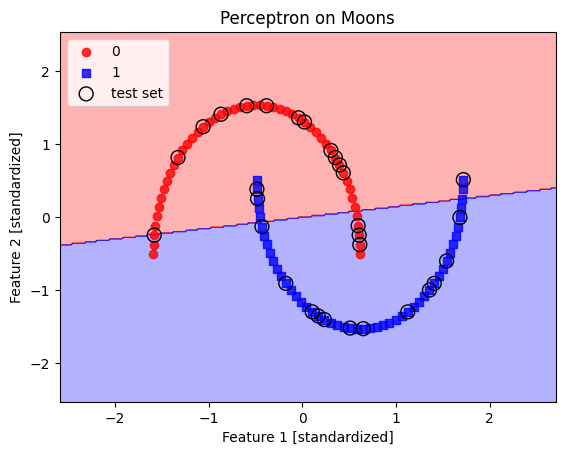

In [3]:
from sklearn.linear_model import Perceptron

eta_values = [0.01, 0.1, 1]
for eta in eta_values:
    ppn = Perceptron(max_iter=40, eta0=eta, random_state=1)
    ppn.fit(X_train_std, y_train)
    y_pred = ppn.predict(X_test_std)
    print(f'Accuracy (eta0={eta}): {accuracy_score(y_test, y_pred):.3f}')
    plot_decision_regions(X_combined_std, y_combined, classifier=ppn,
                          test_idx=range(len(X_train), len(X_combined_std)))
    plt.xlabel('Petal length [standardized]')
    plt.ylabel('Petal width [standardized]')
    plt.title(f'Perceptron (eta0={eta})')
    plt.show()

ppn_moons = Perceptron(max_iter=40, eta0=0.1, random_state=1)
ppn_moons.fit(X_train_m_std, y_train_m)
y_pred_m = ppn_moons.predict(X_test_m_std)
print(f'Moons Accuracy: {accuracy_score(y_test_m, y_pred_m):.3f}')
plot_decision_regions(X_combined_m_std, y_combined_m, classifier=ppn_moons,
                      test_idx=range(len(X_train_m), len(X_combined_m_std)))
plt.xlabel('Feature 1 [standardized]')
plt.ylabel('Feature 2 [standardized]')
plt.title('Perceptron on Moons')
plt.show()

Accuracy (C=0.01): 0.778
Probabilities (first 3 samples): [[0.14911197 0.35062195 0.50026607]
 [0.52478465 0.29602594 0.17918941]
 [0.55343896 0.28384873 0.1627123 ]]


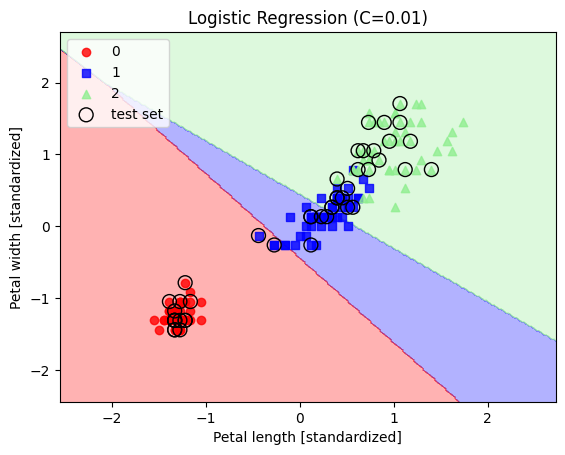

Accuracy (C=1): 0.978
Probabilities (first 3 samples): [[4.78759951e-05 5.94605151e-02 9.40491609e-01]
 [9.08871423e-01 9.11043443e-02 2.42331514e-05]
 [9.49632640e-01 5.03607612e-02 6.59884302e-06]]


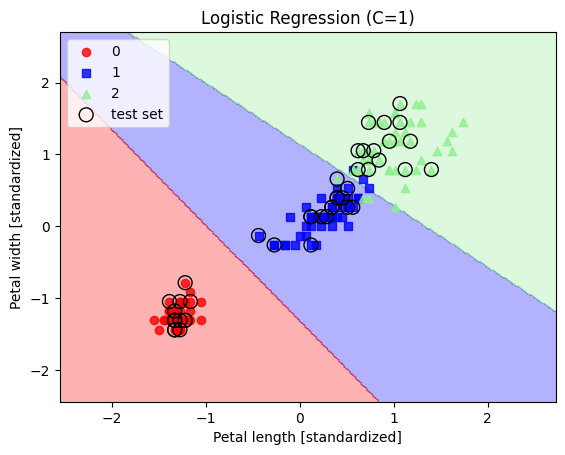

Accuracy (C=100): 0.978
Probabilities (first 3 samples): [[9.37368464e-13 3.91458193e-04 9.99608542e-01]
 [9.93631074e-01 6.36892585e-03 1.20730798e-15]
 [9.98707332e-01 1.29266792e-03 1.82177043e-17]]


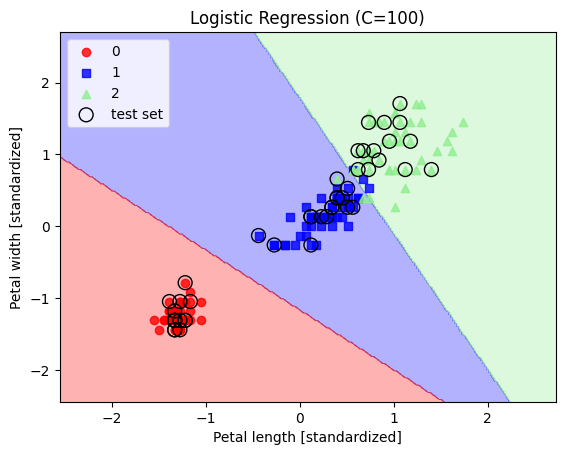

In [4]:
from sklearn.linear_model import LogisticRegression

C_values = [0.01, 1, 100]
for C in C_values:
    lr = LogisticRegression(C=C, random_state=1, solver='lbfgs')  # No multi_class
    lr.fit(X_train_std, y_train)
    y_pred = lr.predict(X_test_std)
    print(f'Accuracy (C={C}): {accuracy_score(y_test, y_pred):.3f}')
    print(f'Probabilities (first 3 samples): {lr.predict_proba(X_test_std[:3])}')
    plot_decision_regions(X_combined_std, y_combined, classifier=lr,
                          test_idx=range(len(X_train), len(X_combined_std)))
    plt.xlabel('Petal length [standardized]')
    plt.ylabel('Petal width [standardized]')
    plt.title(f'Logistic Regression (C={C})')
    plt.show()

Accuracy (C=1.0): 0.978
Support Vectors: 26


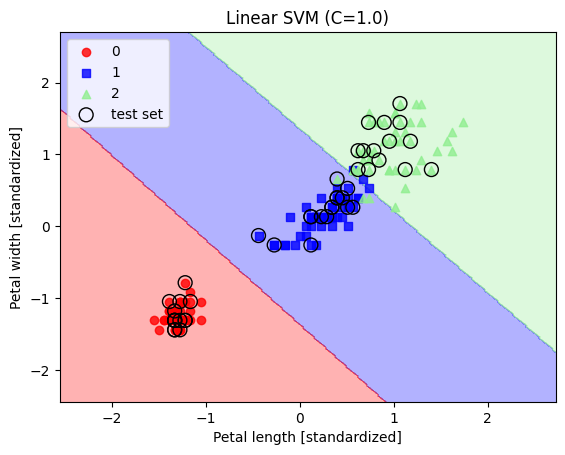

Accuracy (C=100.0): 0.978
Support Vectors: 14


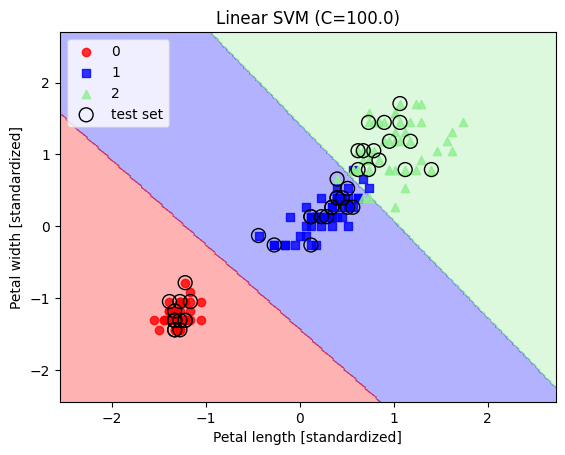

In [5]:
from sklearn.svm import SVC

C_values = [1.0, 100.0]
for C in C_values:
    svm = SVC(kernel='linear', C=C, random_state=1)
    svm.fit(X_train_std, y_train)
    y_pred = svm.predict(X_test_std)
    print(f'Accuracy (C={C}): {accuracy_score(y_test, y_pred):.3f}')
    print(f'Support Vectors: {len(svm.support_vectors_)}')
    plot_decision_regions(X_combined_std, y_combined, classifier=svm,
                          test_idx=range(len(X_train), len(X_combined_std)))
    plt.xlabel('Petal length [standardized]')
    plt.ylabel('Petal width [standardized]')
    plt.title(f'Linear SVM (C={C})')
    plt.show()

Moons Accuracy (gamma=0.01): 0.800


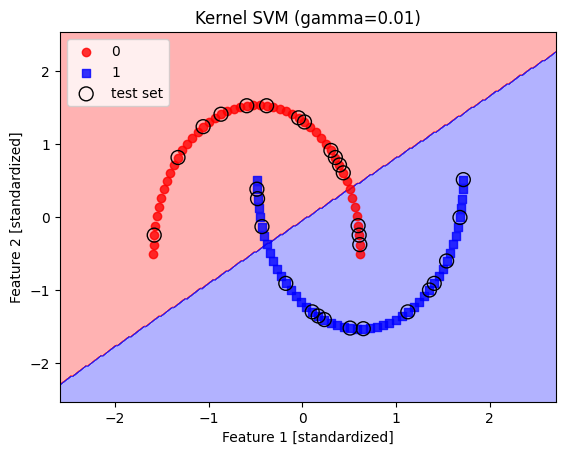

Moons Accuracy (gamma=1): 1.000


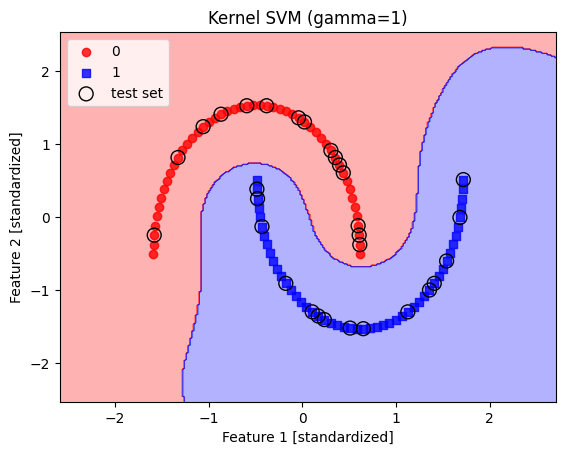

Moons Accuracy (gamma=100): 0.933


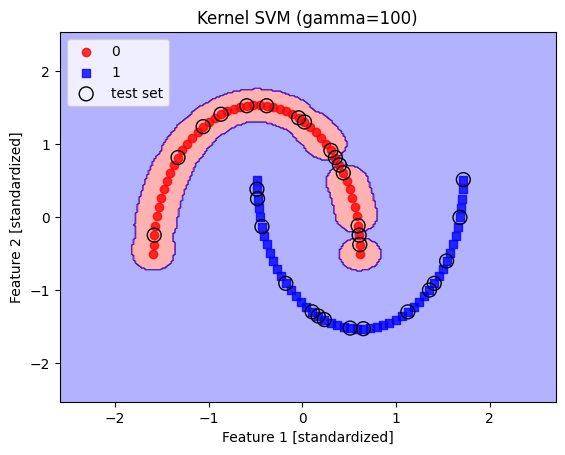

Iris Kernel SVM Accuracy: 0.978


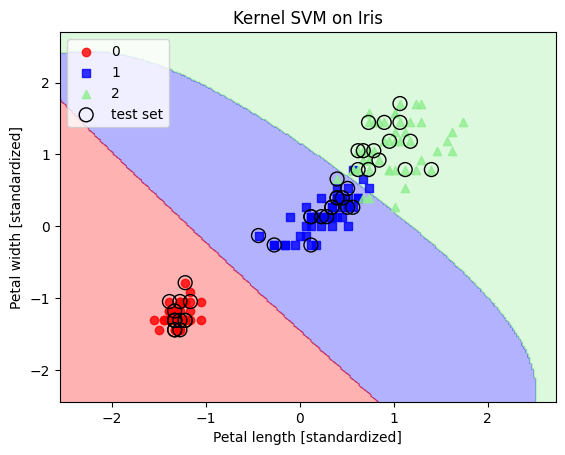

In [6]:
gamma_values = [0.01, 1, 100]
for gamma in gamma_values:
    svm_rbf = SVC(kernel='rbf', random_state=1, gamma=gamma, C=1.0)
    svm_rbf.fit(X_train_m_std, y_train_m)
    y_pred_m = svm_rbf.predict(X_test_m_std)
    print(f'Moons Accuracy (gamma={gamma}): {accuracy_score(y_test_m, y_pred_m):.3f}')
    plot_decision_regions(X_combined_m_std, y_combined_m, classifier=svm_rbf,
                          test_idx=range(len(X_train_m), len(X_combined_m_std)))
    plt.xlabel('Feature 1 [standardized]')
    plt.ylabel('Feature 2 [standardized]')
    plt.title(f'Kernel SVM (gamma={gamma})')
    plt.show()

svm_rbf_iris = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm_rbf_iris.fit(X_train_std, y_train)
y_pred_iris = svm_rbf_iris.predict(X_test_std)
print(f'Iris Kernel SVM Accuracy: {accuracy_score(y_test, y_pred_iris):.3f}')
plot_decision_regions(X_combined_std, y_combined, classifier=svm_rbf_iris,
                      test_idx=range(len(X_train), len(X_combined_std)))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.title('Kernel SVM on Iris')
plt.show()

Accuracy (gini, max_depth=1): 0.667


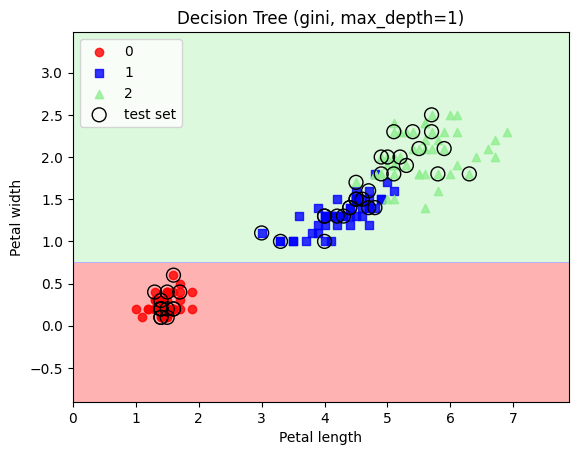

Accuracy (gini, max_depth=4): 0.978


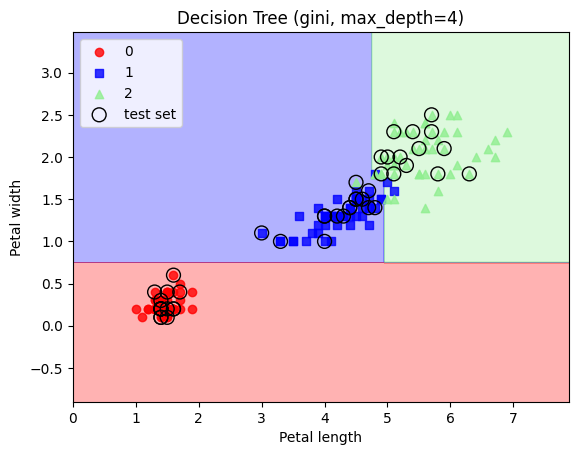

Accuracy (gini, max_depth=10): 0.978


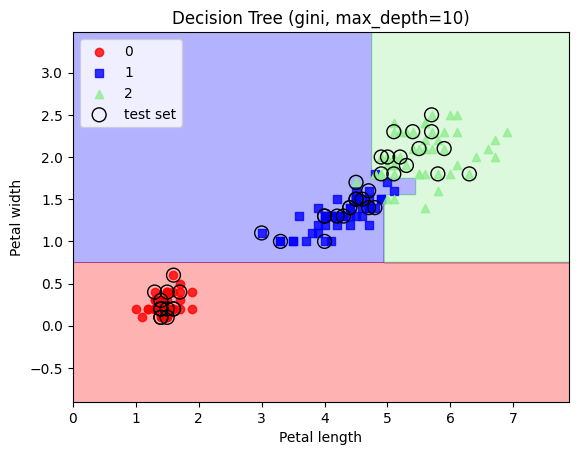

Accuracy (entropy, max_depth=1): 0.667


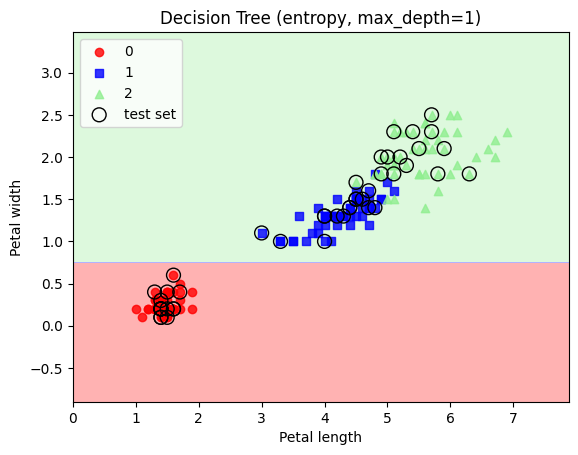

Accuracy (entropy, max_depth=4): 0.933


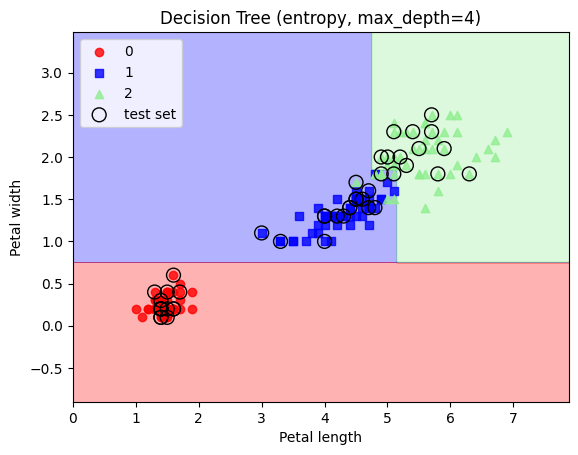

Accuracy (entropy, max_depth=10): 0.978


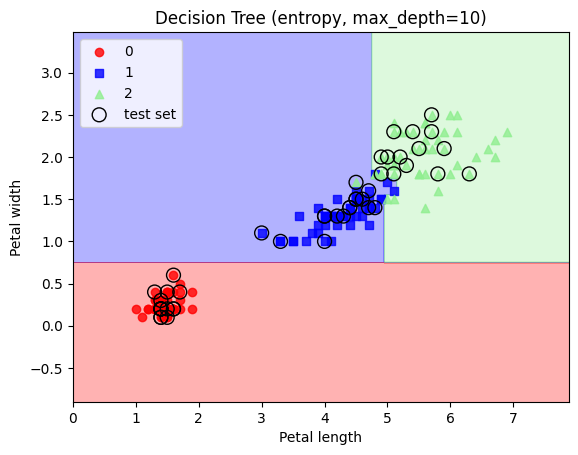

In [7]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from pydotplus import graph_from_dot_data

depths = [1, 4, 10]
criteria = ['gini', 'entropy']
for criterion in criteria:
    for depth in depths:
        tree = DecisionTreeClassifier(criterion=criterion, max_depth=depth, random_state=1)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_test)
        print(f'Accuracy ({criterion}, max_depth={depth}): {accuracy_score(y_test, y_pred):.3f}')
        plot_decision_regions(X_combined, y_combined, classifier=tree,
                              test_idx=range(len(X_train), len(X_combined)))
        plt.xlabel('Petal length')
        plt.ylabel('Petal width')
        plt.title(f'Decision Tree ({criterion}, max_depth={depth})')
        plt.show()

        dot_data = export_graphviz(tree, filled=True, rounded=True,
                                  class_names=['Setosa', 'Versicolor', 'Virginica'],
                                  feature_names=['petal length', 'petal width'], out_file=None)
        graph = graph_from_dot_data(dot_data)
        graph.write_png(f'tree_{criterion}_depth{depth}.png')

Accuracy (n_estimators=25): 0.978
OOB Score: 0.952
Feature Importances: [0.52140135 0.47859865]


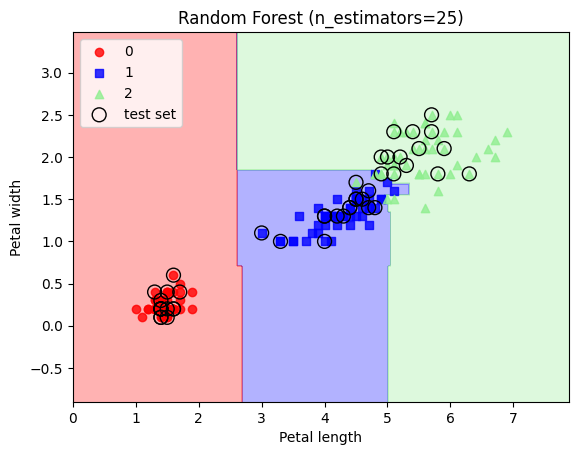

Accuracy (n_estimators=100): 0.978
OOB Score: 0.943
Feature Importances: [0.48273366 0.51726634]


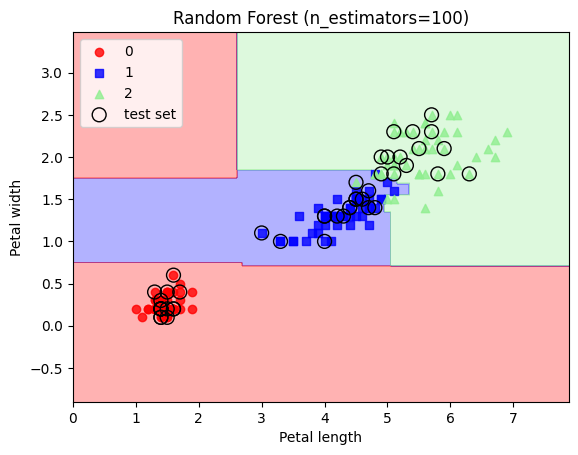

In [8]:
from sklearn.ensemble import RandomForestClassifier

n_estimators_values = [25, 100]
for n_est in n_estimators_values:
    forest = RandomForestClassifier(criterion='gini', n_estimators=n_est, random_state=1, n_jobs=2, oob_score=True)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    print(f'Accuracy (n_estimators={n_est}): {accuracy_score(y_test, y_pred):.3f}')
    print(f'OOB Score: {forest.oob_score_:.3f}')
    print(f'Feature Importances: {forest.feature_importances_}')
    plot_decision_regions(X_combined, y_combined, classifier=forest,
                          test_idx=range(len(X_train), len(X_combined)))
    plt.xlabel('Petal length')
    plt.ylabel('Petal width')
    plt.title(f'Random Forest (n_estimators={n_est})')
    plt.show()

Accuracy (euclidean, n_neighbors=1): 0.978


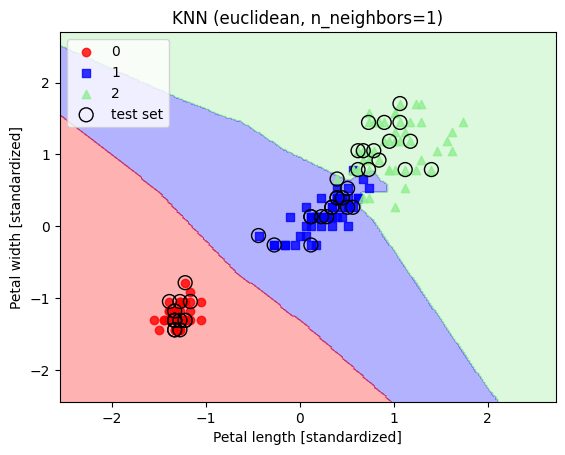

Accuracy (euclidean, n_neighbors=5): 1.000


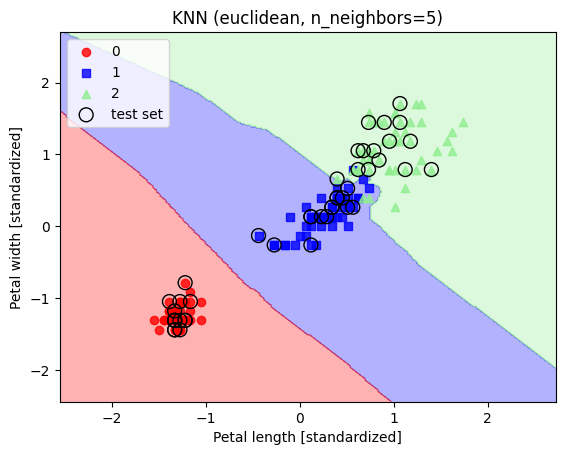

Accuracy (euclidean, n_neighbors=10): 0.978


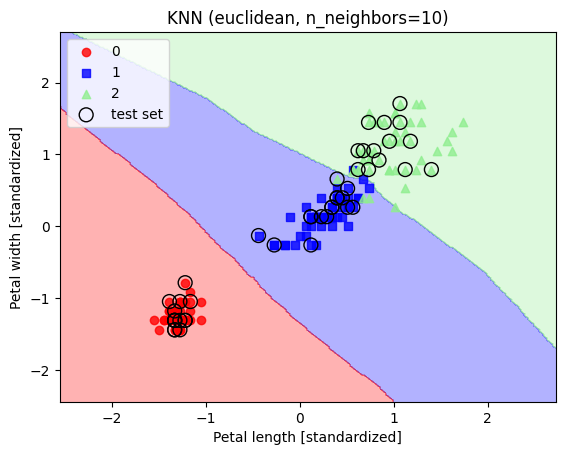

Accuracy (manhattan, n_neighbors=1): 0.978


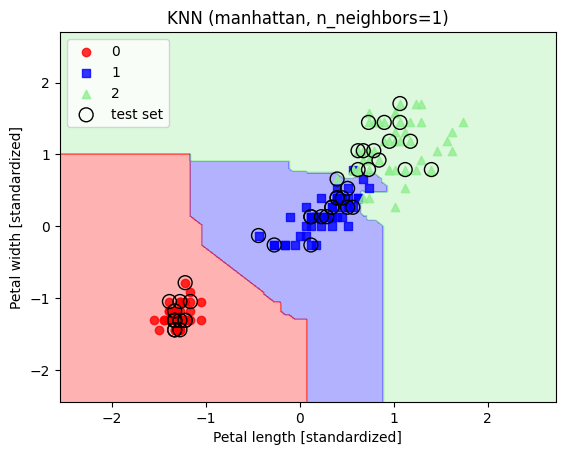

Accuracy (manhattan, n_neighbors=5): 0.978


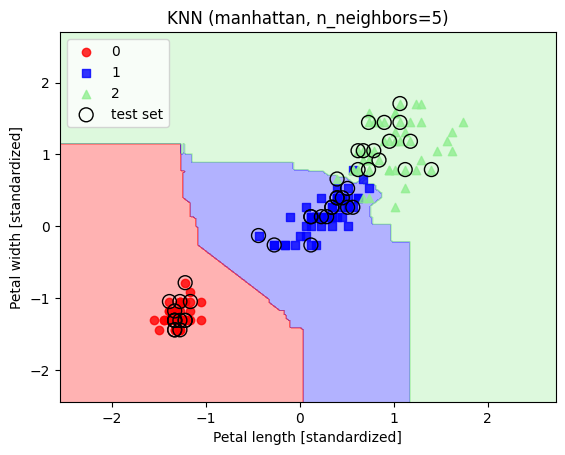

Accuracy (manhattan, n_neighbors=10): 0.978


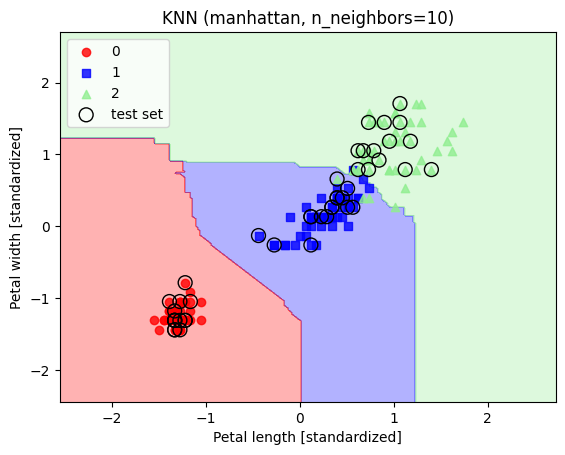

In [9]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors_values = [1, 5, 10]
metrics = {'euclidean': 2, 'manhattan': 1}
for metric_name, p in metrics.items():
    for n in n_neighbors_values:
        knn = KNeighborsClassifier(n_neighbors=n, p=p, metric='minkowski')
        knn.fit(X_train_std, y_train)
        y_pred = knn.predict(X_test_std)
        print(f'Accuracy ({metric_name}, n_neighbors={n}): {accuracy_score(y_test, y_pred):.3f}')
        plot_decision_regions(X_combined_std, y_combined, classifier=knn,
                              test_idx=range(len(X_train), len(X_combined_std)))
        plt.xlabel('Petal length [standardized]')
        plt.ylabel('Petal width [standardized]')
        plt.title(f'KNN ({metric_name}, n_neighbors={n})')
        plt.show()

In [10]:
from sklearn.model_selection import GridSearchCV

# Grid search for Logistic Regression
param_grid_lr = {'C': [0.1, 1, 10, 100]}
grid_lr = GridSearchCV(LogisticRegression(random_state=1, solver='lbfgs'), param_grid_lr, cv=5)
grid_lr.fit(X_train_std, y_train)
print('Logistic Regression Best params:', grid_lr.best_params_)
print('Logistic Regression Best score:', grid_lr.best_score_)

# Grid search for KNN
param_grid_knn = {'n_neighbors': [1, 5, 10], 'p': [1, 2]}
grid_knn = GridSearchCV(KNeighborsClassifier(metric='minkowski'), param_grid_knn, cv=5)
grid_knn.fit(X_train_std, y_train)
print('KNN Best params:', grid_knn.best_params_)
print('KNN Best score:', grid_knn.best_score_)

# Compare models
models = {
    'Perceptron': Perceptron(max_iter=40, eta0=0.1, random_state=1),
    'LogReg': LogisticRegression(C=1.0, random_state=1, solver='lbfgs'),
    'SVM': SVC(kernel='linear', C=1.0, random_state=1),
    'Kernel_SVM': SVC(kernel='rbf', gamma=1.0, C=1.0, random_state=1),
    'Tree': DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1),
    'Forest': RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1),
    'KNN': KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
}

print("\nIris Accuracies:")
for name, model in models.items():
    model.fit(X_train_std if name in ['Perceptron', 'LogReg', 'SVM', 'Kernel_SVM', 'KNN'] else X_train, y_train)
    y_pred = model.predict(X_test_std if name in ['Perceptron', 'LogReg', 'SVM', 'Kernel_SVM', 'KNN'] else X_test)
    print(f'{name}: {accuracy_score(y_test, y_pred):.3f}')

print("\nMoons Accuracies:")
for name, model in models.items():
    model.fit(X_train_m_std if name in ['Perceptron', 'LogReg', 'SVM', 'Kernel_SVM', 'KNN'] else X_train_m, y_train_m)
    y_pred = model.predict(X_test_m_std if name in ['Perceptron', 'LogReg', 'SVM', 'Kernel_SVM', 'KNN'] else X_test_m)
    print(f'{name}: {accuracy_score(y_test_m, y_pred):.3f}')

Logistic Regression Best params: {'C': 0.1}
Logistic Regression Best score: 0.9523809523809523
KNN Best params: {'n_neighbors': 1, 'p': 1}
KNN Best score: 0.9714285714285713

Iris Accuracies:
Perceptron: 0.978
LogReg: 0.978
SVM: 0.978
Kernel_SVM: 0.978
Tree: 0.978
Forest: 0.978
KNN: 1.000

Moons Accuracies:
Perceptron: 0.767
LogReg: 0.800
SVM: 0.800
Kernel_SVM: 1.000
Tree: 0.833
Forest: 0.967
KNN: 1.000
